In [10]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np


os.chdir('../raw_data')


In [2]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'data.json',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'GNPS_spectra_toconfirm',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_corr',
 'ms2ds_pred_corr_tanimoto',
 'ms2ds_pred_cos.filepart',
 'ms2ds_pred_cos_tanimoto',
 'ms2ds_pred_euc',
 'ms2ds_pred_euc_tanimoto

#### Functions to load and or write to pickle files

In [3]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [4]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(41447, 8)

In [96]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['spec2vec']]), np.array([x for x in test_df['spec2vec']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['spec2vec']]), np.array([x for x in val_df['mol2vec']])

In [97]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])
batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                            num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [ ]:


%%time
#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 100
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)


print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(500,300,300))
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(500,300,300))

# define variant algorithmns

#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

# 2. SDL
sdl = DCCA_SDL(latent_dims,optimizer='sgd',
                N=N, encoders=[encoder_1, encoder_2],
                lam=0.0001, lr=lr,
                objective=objectives.CCA,) # train size

# # Define the trainer
# #dcca
# trainer_dcca = pl.Trainer(
#         max_epochs=epochs, log_every_n_steps=1)

#sdl
trainer_sdl = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

# # # train
# print('\n','-'*20,'\n Training DCCA\n','-'*20)
# trainer_dcca.fit(dcca, train_loader,val_loader)
print('\n','-'*20,'\n Training SDL\n','-'*20)
trainer_sdl.fit(sdl, train_loader,val_loader)

#transform the views to get z projections



 -------------------- 
 Training CCA
 --------------------


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 842 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
842 K     Trainable params
0         Non-trainable params
842 K     Total params
3.370     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [99]:
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_test, v2_test])

In [100]:
dcca_train_corr = dcca.score(train_loader)
dcca_train_corr[0:5]

array([0.93480031, 0.92872664, 0.91856955, 0.90947563, 0.89422754])

In [101]:
dcca_test_corr = dcca.score(test_loader)
dcca_test_corr[0:5]

array([0.89837434, 0.88754312, 0.84125799, 0.82955302, 0.81504135])

In [ ]:
sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

In [ ]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

In [104]:
embedding = 'Spec2Vec'
method = 'ALL_3_hidden'

In [105]:
#sns.color_palette("colorblind")

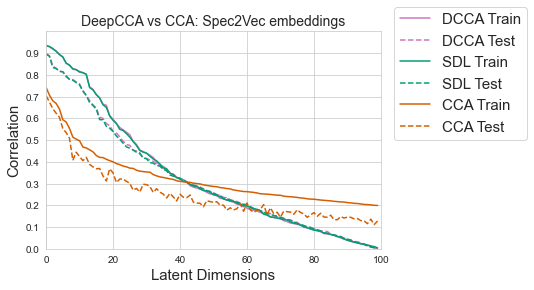

In [106]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                  'SDL Train', 'SDL Test',\
                  'CCA Train', 'CCA Test'], loc=(1.04, 0.5), fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)
plt.yticks(np.arange(0, 1, step=0.1))
plt.savefig(f'../plots/{method}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

In [78]:
# score test dataset
# check the validation loop warning

In [76]:
v2_val.shape

(1244, 300)